In [1]:
import tensorflow as tf
#import imageio
import numpy as np
import edward as ed
#import pystan
import os
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import time
import seaborn as sns
from edward.models import Categorical, Dirichlet, InverseGamma, Normal, MultivariateNormalDiag, Mixture, Empirical, ParamMixture
%matplotlib inline

In [2]:
img_no = 2092

In [3]:
#train_path = "/Users/leah/Columbia/courses/ml_prob_programming/ENV/BSR/BSDS500/data/images/train"
train_path = "../data/BSR/BSDS500/data/images/train/{}.jpg".format(img_no)

In [4]:
img = plt.imread(train_path)

In [55]:
img.shape

(321, 481, 3)

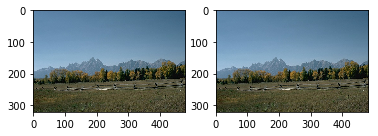

In [6]:
fig = plt.figure()
fig.add_subplot(1,2,1)
plt.imshow(img)
fig.add_subplot(1,2,2)
plt.imshow(img)
plt.show()

In [7]:
train_img = img.reshape(-1, 3).astype(int)

In [64]:
train_img.shape

(154401, 3)

# MCMC

In [9]:
# Hyperparameters
# 11/5/2018此处已经改动
N = train_img.shape[0] 
K = 7
D = train_img.shape[1]
ed.set_seed(67)

In [10]:
train_img.shape

(154401, 3)

In [11]:
with tf.name_scope("model"):
    pi = Dirichlet(concentration=tf.constant([1.0] * K, name="pi/weights"), name= "pi")
    mu = Normal(loc= tf.zeros(D, name="centroids/loc"), 
                scale= tf.ones(D, name="centroids/scale"), 
                sample_shape=K, name= "centroids")
    sigma = InverseGamma(concentration=tf.ones(D, name="variability/concentration"), 
                         rate=tf.ones(D, name="variability/rate"), sample_shape=K, name= "variability")
    #cat = Categorical(probs= pi, sample_shape= N)

    x = ParamMixture(pi, {'loc': mu, 'scale_diag': tf.sqrt(sigma)},
                     MultivariateNormalDiag,
                     sample_shape=N, name= "mixture")
    z = x.cat
    #z = tf.identity(z, name="categ")
# should use joint version instead

#components = [
#    MultivariateNormalDiag(mu[k], sigma[k], sample_shape=N)
#    for k in range(K)]
#x = Mixture(cat, components)

In [12]:
T = 200  # number of MCMC samples
with tf.name_scope("posterior"):
    qpi = Empirical(tf.get_variable(
        "qpi/params", [T, K],
        initializer=tf.constant_initializer(1.0/K)))
    qmu = Empirical(tf.get_variable(
        "qmu/params", [T, K, D],
        initializer=tf.zeros_initializer()))
    qsigma = Empirical(tf.get_variable(
        "qsigma/params", [T, K, D],
        initializer=tf.ones_initializer()))
    qz = Empirical(tf.get_variable(
        "qz/params", [T, N],
        initializer=tf.zeros_initializer(),
        dtype=tf.int32))

In [13]:
qmu

<ed.RandomVariable 'posterior/Empirical_1/' shape=(7, 3) dtype=float32>

In [14]:
inference = ed.Gibbs({pi: qpi, mu: qmu, sigma: qsigma, z: qz},
                     data={x: train_img})

/Users/zhonglingjiang/anaconda3/envs/mlprobprog/lib/python3.6/site-packages/edward/util/random_variables.py:52: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  not np.issubdtype(value.dtype, np.float) and \
/Users/zhonglingjiang/anaconda3/envs/mlprobprog/lib/python3.6/site-packages/edward/util/random_variables.py:53: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  not np.issubdtype(value.dtype, np.int) and \


In [15]:
inference.initialize(n_print=50, logdir='log/IMG={}_K={}_T={}'.format(img_no, K, T))
sess = ed.get_session()
tf.global_variables_initializer().run()
t_ph = tf.placeholder(tf.int32, [])
running_cluster_means = tf.reduce_mean(qmu.params[:t_ph], 0)

In [16]:
learning_curve = []
for _ in range(inference.n_iter):
    info_dict = inference.update()
    inference.print_progress(info_dict)
    t = info_dict['t']
    if t % inference.n_print == 0:
        print("\nInferred cluster means:")
        posterior_mu = sess.run(running_cluster_means, {t_ph: t - 1})
        print(posterior_mu)
inference.finalize()

 50/200 [ 25%] ███████                        ETA: 224s | Acceptance Rate: 1.000
Inferred cluster means:
[[120.546814 150.4061   168.37122 ]
 [ 15.006934  16.92099   13.942142]
 [ 31.334356  36.861904  23.537334]
 [ 68.11498   69.073784  45.491417]
 [ 89.68847   88.94739   65.57652 ]
 [ 39.748756  44.115997  32.432102]
 [ 93.62231  127.46299  153.86192 ]]
100/200 [ 50%] ███████████████                ETA: 152s | Acceptance Rate: 1.000
Inferred cluster means:
[[122.388985  154.93028   178.51631  ]
 [  7.3836484   8.360445    6.9683604]
 [ 24.805628   30.274305   17.642239 ]
 [ 65.20511    65.72967    41.16931  ]
 [ 89.469284   87.48225    62.65846  ]
 [ 21.49863    22.670797   16.256464 ]
 [ 92.466286  126.81389   154.01968  ]]
150/200 [ 75%] ██████████████████████         ETA: 76s | Acceptance Rate: 1.000 
Inferred cluster means:
[[123.003395  156.4324    181.86856  ]
 [  4.9433837   5.5339613   4.6016397]
 [ 22.519691   27.993288   15.646273 ]
 [ 64.146194   64.54       39.6707   ]
 [

(array([3.6872e+04, 1.0000e+00, 0.0000e+00, 9.8720e+03, 0.0000e+00,
        2.2683e+04, 2.9761e+04, 0.0000e+00, 3.1000e+01, 5.5181e+04]),
 array([0. , 0.6, 1.2, 1.8, 2.4, 3. , 3.6, 4.2, 4.8, 5.4, 6. ]),
 <a list of 10 Patch objects>)

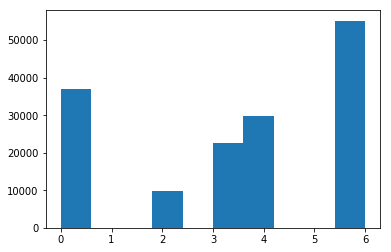

In [17]:
plt.hist(qz.eval())

In [18]:
posterior_mu

array([[123.32508  , 157.19247  , 183.54625  ],
       [  3.6801405,   4.1867642,   3.4377067],
       [ 21.418253 ,  26.872019 ,  14.656558 ],
       [ 63.622555 ,  63.95426  ,  38.92228  ],
       [ 89.28392  ,  86.68595  ,  61.159885 ],
       [ 12.289861 ,  11.878401 ,   8.520612 ],
       [ 91.9139   , 126.50138  , 154.12022  ]], dtype=float32)

In [19]:
# Calculate likelihood for each data point and cluster assignment,
# averaged over many posterior samples. ``x_post`` has shape (N, 100, K, D).
M = 100 #这步可以提前和mu sigma一起sample
mu_sample = qmu.sample(M)
sigmasq_sample = qsigma.sample(M)
pi_sample = qpi.sample(M)
x_post = Normal(loc=tf.ones([N, 1, 1, 1]) * mu_sample,
                scale=tf.ones([N, 1, 1, 1]) * tf.sqrt(sigmasq_sample))
x_broadcasted = tf.tile(tf.reshape(train_img, [N, 1, 1, D]), [1, M, K, 1])
x_broadcasted = tf.cast(x_broadcasted, dtype= tf.float32)

In [24]:
# Sum over latent dimension, then average over posterior samples.
# ``log_liks`` ends up with shape (N, K).
log_liks = x_post.log_prob(x_broadcasted)
log_liks = tf.reduce_sum(log_liks, 3) 
log_liks = tf.reduce_mean(log_liks, 1)

(154401, 100, 7, 3)
(154401, 100, 7)
(154401, 7)


In [26]:
clusters = tf.argmax(log_liks, 1).eval()

(array([35031.,  1450.,     0.,  8010.,     0., 22212., 30690.,     0.,
           78., 56930.]),
 array([0. , 0.6, 1.2, 1.8, 2.4, 3. , 3.6, 4.2, 4.8, 5.4, 6. ]),
 <a list of 10 Patch objects>)

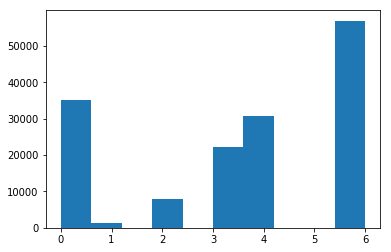

In [27]:
plt.hist(clusters)

In [28]:
new_img = tf.gather(running_cluster_means, tf.argmax(log_liks, 1))

In [29]:
clusters.shape

(154401,)

In [30]:
clusters.reshape(img.shape[0], img.shape[1])

array([[6, 6, 6, ..., 6, 5, 1],
       [6, 6, 6, ..., 6, 5, 1],
       [6, 6, 6, ..., 6, 6, 1],
       ...,
       [3, 3, 3, ..., 3, 4, 3],
       [3, 3, 2, ..., 3, 4, 3],
       [3, 3, 3, ..., 3, 3, 3]])

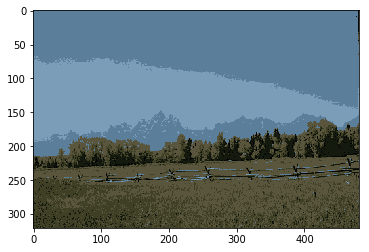

In [31]:
nrows, ncols = img.shape[0], img.shape[1]
segmented_img = np.zeros((nrows, ncols, D),dtype='int')
cluster_reshape = clusters.reshape(nrows, ncols)
for i in range(nrows):
    for j in range(ncols):
        cluster_number = cluster_reshape[i, j]
        segmented_img[i, j] = posterior_mu[cluster_number].astype(int)
fig = plt.figure()
plt.imshow(segmented_img)
timestr = time.strftime("%Y%m%d-%H%M%S")
plt.savefig('../tmp/img={}_K={}_T={}_Time={}.png'.format(img_no, K, T, timestr))

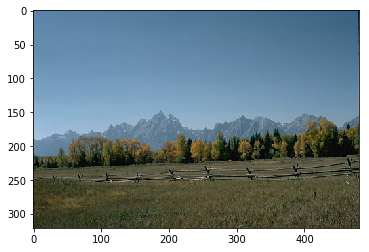

In [32]:
plt.imshow(img)

## Criticism

### Posterior Predictive

1. Sample from posterior q$(\pi)$ (M = 100 samples). Exponentiate `log_liks` to get $p_k = exp(pi_i)$
2. Calculate mixture likelihood for each sample of pi. $p(x | \pi_i) = \sum_{k = 1}^K \pi_{ik} * p_k$ where k is a class.
3. Average over all $p(x | \pi_i)$ for i = 1 to M.
4. Take product of all likelihood over $x$ (value too small) OR sum of log likelihood over $x$

In [33]:
# Step 1: 
 # (100 * K)
#p_k = tf.exp(log_liks) # (N * K)
#weighted_liks = tf.matmul(pi_sample, tf.transpose(p_k))  
#log_expected_liks = tf.log(tf.reduce_mean(weighted_liks, 0))
#total_log_expected_liks = tf.reduce_sum(log_expected_liks, 0)

In [36]:
# modify defintion # wrong
#log_liks_over_all_points = tf.reduce_sum(log_liks, 0)
# no log sum trick
#max_x_i = 
#liks_over_all_points = tf.expand_dims(tf.exp(log_liks_over_all_points),0)
#total_log_expected_liks_2 = tf.reduce_mean(tf.log(tf.matmul(liks_over_all_points, tf.transpose(pi_sample))))

In [58]:
# correction part
log_liks_3 = x_post.log_prob(x_broadcasted)
log_liks_3 = tf.reduce_sum(log_liks_3, 3)
pi_samples_tiled_3 = tf.tile(tf.expand_dims(pi_sample, 0), [N, 1,1]) # [500, 100, 7], [N, M, K]
sum_log_pi_normal_3 = tf.add(pi_samples_tiled_3,log_liks_3) # [500, 100, 7]
x_max_3 = tf.reduce_max(sum_log_pi_normal_3, axis=2) # [500, 100]
edited_log_sum_3 = tf.add(x_max_3, tf.log(tf.reduce_sum(tf.exp(sum_log_pi_normal_3 - tf.expand_dims(x_max_3, 2)), axis=2))) #[500, 100]
averaged_total_log_liks_over_pi_samples_3 = tf.reduce_mean(tf.reduce_sum(c, 0), 0)


In [37]:
# using log sum trick
#log_pi_sample = tf.log(pi_sample)    #错误: 在上一步时log_liks 不应该合并先100个(mu, sigma)sample. 而是应该把pi 与这些(mu,sigma)并列。

#pi_sample_expand = tf.expand_dims(tf.log(pi_sample), 1) #[100, 1, 7]
#sum_log_pi_normal = tf.add(pi_sample_expand,log_liks) # [100, N, 7]
#x_max = tf.reduce_max(sum_log_pi_normal, axis=2) #[100, N]
#edited_log_sum = tf.add(x_max, tf.log(tf.reduce_sum(tf.exp(sum_log_pi_normal - tf.expand_dims(x_max, 2)), axis=2))) # [100, N]  # log (sum_i(exp(x_i-x_max)))
#averaged_total_log_liks_over_pi_samples = tf.reduce_mean(tf.reduce_sum(edited_log_sum, 1), 0)

In [59]:
total_total_log_liks_value = sess.run(averaged_total_log_liks_over_pi_samples_3)

-1788994.8


In [42]:
with open('../tmp/log/log_likelihood.txt', 'w') as fp:
    if os.stat("../tmp/log/log_likelihood.txt").st_size == 0:
        fp.write("img,K,T,log_lik\n")
    fp.write("{},{},{},{}\n".format(img_no, K, T,total_total_log_liks_value))
print('The data log likeilhood is: {}'.format(total_total_log_liks_value))
#print('The data likeilhood using log sum trick is: {}'.format(averaged_total_log_liks_over_pi_samples))

The data likeilhood is: -2130653.0


In [43]:
# evaluate mean square error
#ed.evaluate('mean_squared_error', data={tf.reshape(segmented_img, [-1, D]): train_img})

Question: Instead of using this, can we directly use x_post.log_prob(train_img)? or related?

In [44]:
#x_train_broadcasted = tf.tile(tf.reshape(train_img, [N, 1, 1, D]), [1, 100, K, 1])
#x_train_broadcasted = tf.cast(x_train_broadcasted, dtype= tf.float32)

In [45]:
#ed.evaluate('log_likelihood', data={x_post: x_train_broadcasted}, n_samples=1)

### Posterior Dispersion Index (PDI) and WAPDI

Reference: http://proceedings.mlr.press/v70/kucukelbir17a/kucukelbir17a.pdf

Citation: Kucukelbir, Alp, Yixin, Wang and Blei, David M. Evaluating Bayesian Models with Posterior Dispersion Indices, In $\textit{Proceedings
of the 34th International Conference on Machine Learning,
volume 70 of Proceedings of Machine Learning Research}$,
pages 1925–1934, International Convention Centre, Sydney,
Australia, 06–11 Aug 2017.

Goal: 

Evalute the quantity $\frac{V_{\theta|x} [p(x_n |\theta)]}{E_{\theta|x} [p(x_n |\theta)]}$ for each point $x_n$

Alternatively, evaluate the quantity $\frac{V_{\theta|x} [logp(x_n |\theta)]}{E_{\theta|x} [logp(x_n |\theta)]}$

Steps:
1. We look at a single data point $x_n$ first.
2. Compute the posterior distribution $p(\theta | x)$
3. Sample ${\theta_1, ..., \theta_m}$ where $\theta_i \sim p(\theta|x)$  (In this problem, we need to sample $\pi$)
4. For each $\theta_i$, calculate the likelihood $lik_{ni} = p(x_n | \theta_i)$. Collect $Lik_n = \{lik_{n1}, ..., lik_{nm}\}$
5. Calculate $Var(Lik_n)$ and $Exp(Lik_n)$
6. Repeat the computation for all data points.

During Implementation, we make use of the `log_liks` in the computation graph before, but instead of reducing both 2nd and 4th dimension, we now only reduce 4th dimension because we want to keep these samples. 

In [73]:
# 1. PDI
pi_samples_tiled_3 = tf.tile(tf.expand_dims(pi_sample, 0), [N, 1,1]) # [500, 100, 7], [N, M, K]
p_x_given_theta_3 = tf.reduce_sum(tf.multiply(pi_samples_tiled_3, tf.exp(log_liks_3)), axis=2) 
pdi_mean, pdi_variance = tf.nn.moments(p_x_given_theta_3, axes=[1])
pdi = tf.divide(pdi_variance, pdi_mean)
pdi_values = sess.run(pdi)

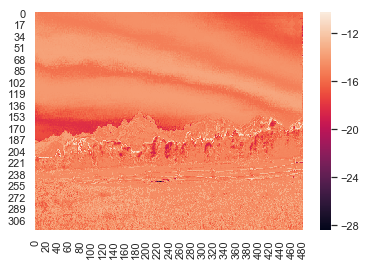

In [78]:
# generate x and y of image
sns.set()
nrows, ncols = img.shape[0], img.shape[1]
reshaped_pdi_values = np.reshape(pdi_values, (nrows, ncols))
ax = sns.heatmap(np.log(reshaped_pdi_values))

In [76]:
# WAPDI
_, wapdi_variance = tf.nn.moments(tf.log(p_x_given_theta_3), axes=[1])
wapdi_log_mean = tf.log(pdi_mean)
wapdi = tf.divide(wapdi_variance, wapdi_log_mean)
wapdi_values = sess.run(wapdi)

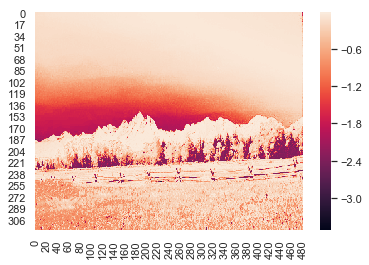

In [77]:
sns.set()
reshaped_wapdi_values = np.reshape(wapdi_values, (nrows, ncols))
ax = sns.heatmap(reshaped_wapdi_values)

## Next Step
1. Set N_iter = 100, 200, 300, 400, 500
2. Record the log_likelihood across all N_iter
3. Implement PDI and WAPDI
4. Logging these result [important]
3. Change initialization method. See if that would affect result